## What is a baseline model?

In image classification, a baseline is a simple and effective model used as a point of reference for evaluating the performance of more complex models. The purpose of establishing a baseline is to have a standard for comparison to determine whether the more complex models actually improve the accuracy of the classification task. Following are the qualities of a baseline model:

1) easy to train 
2) easy to test 
3) easy to interpret 


## Set up

In [2]:
from fastai.vision.all import *

set_seed(42)

In [3]:
trn_path = '/kaggle/input/ideitify'
files = get_image_files(trn_path)

## Choose an architecture

Let's train a model.

FastAI has several ResNet models in readily available:

Resnet18
Resnet34
Resnet50
Resnet101
Resnet152

They vary in size, with ResNet152 being trained on the most amount of images.

For the basline, I will use <code>resnet18</code>. It is a relatively shallow neural network, with only 18 layers, which makes it easier to train and faster to run than deeper networks. Despite its relative simplicity, it has been shown to achieve high accuracy on several benchmark image classification datasets, such as ImageNet. 

In [4]:
arch = "resnet18"

## Presizing

Images scraped from the web comes in all shapes and sizes. Images have to be resized to a fixed dimension so that they can be packed into a batch tensor to be passed to the GPU. So we need to add a transform that will do the job.

Fastai does this job by implementing presizing. It is a data augmentation strategy that is designed to minimize data destruction while maintaing good performance. There are two steps to this strategy:

1) use Resize (crop, squish or pad) as an item transform with a relatively higher size than the target size.\
2) use RandomResizedCrop as a batch transform using aug_transform(size, min_scale)

In [18]:
def train(
    item_tfms=Resize(256), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75), 
    epochs=5
    ):
    
    dls = ImageDataLoaders.from_folder(
        trn_path, valid_pct=0.2, seed=42,
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )
    learn = vision_learner(dls, arch, metrics=[error_rate], path='.').to_fp16()
    learn.fit_one_cycle(epochs, 0.01)
    return learn

## About fit_one_cycle() method

<code>1cycle policy</code> was introduced by Leslie Smith’s in this [paper](http://arxiv.org/abs/1708.07120). In this policy, learning rate starts at a low value, increases to a very large value and then decreases to a value much lower than its initial one. The cycle’s size must be smaller than the total number of training iterations/epochs. After the cycle is complete, the learning rate should decrease even further for the remaining iterations/epochs, several orders of magnitude less than its initial value.

Fastai abstracts all the implementation details of the 1cycle policy and provides an api in the form of <code>fit_one_cycle()</code> method. The latter calls <code>fit()</code> method internally, appending an <code>OneCycleScheduler</code> callback.

In [19]:
train()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.937966,2.250741,0.553651,02:44
1,2.374840,1.800852,0.509206,02:37
2,1.931534,1.553279,0.462222,02:39
3,1.579504,1.336386,0.393651,02:42
4,1.367857,1.297876,0.381587,02:43


In [21]:
train(item_tfms=Resize(256, method=ResizeMethod.Squish))

epoch,train_loss,valid_loss,error_rate,time
0,2.821254,2.347209,0.577143,02:57
1,2.225851,1.905693,0.530159,02:56
2,1.781943,1.488386,0.431111,02:59
3,1.375893,1.257750,0.384762,02:56
4,1.143443,1.197577,0.358730,02:58


In [22]:
train(item_tfms=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))

epoch,train_loss,valid_loss,error_rate,time
0,2.971016,2.568800,0.612063,02:58
1,2.295279,1.831932,0.516825,02:57
2,1.834159,1.549262,0.455873,02:57
3,1.492705,1.303364,0.374603,02:56
4,1.212536,1.264848,0.366349,02:57


Although they don't make a huge difference, squishing the images shows some promise.

## Train baseline model

In [24]:
learn = train(
    item_tfms=Resize(256, method=ResizeMethod.Squish), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75), 
    epochs=20
)

epoch,train_loss,valid_loss,error_rate,time
0,3.230281,2.071357,0.570794,02:58
1,2.268028,1.683748,0.460952,02:56
2,1.931177,1.768401,0.516825,02:59
3,1.874281,1.944095,0.509206,02:57
4,1.770783,1.717826,0.470476,02:59
5,1.624989,1.546102,0.438095,02:09
6,1.484330,1.564416,0.460317,01:42
7,1.351104,1.493290,0.431111,01:43
8,1.276725,1.337325,0.391111,01:44
9,1.229016,1.320946,0.375873,01:43


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x73da7a764560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x73da7a764560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

## Interpretation

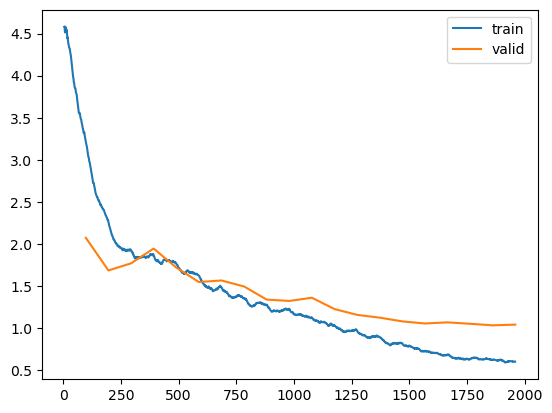

In [25]:
learn.recorder.plot_loss()

In [29]:
interp =  ClassificationInterpretation.from_learner(learn)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x73da7a764560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x73da7a764560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

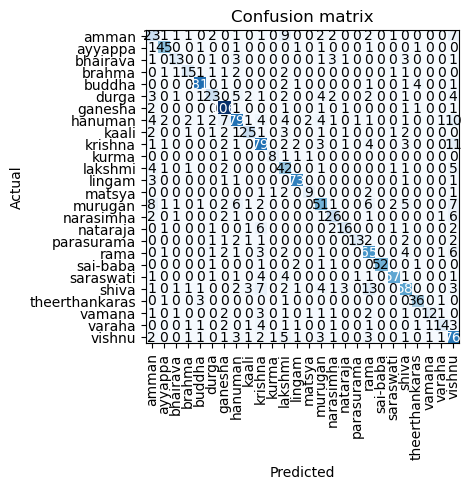

In [31]:
interp.plot_confusion_matrix()

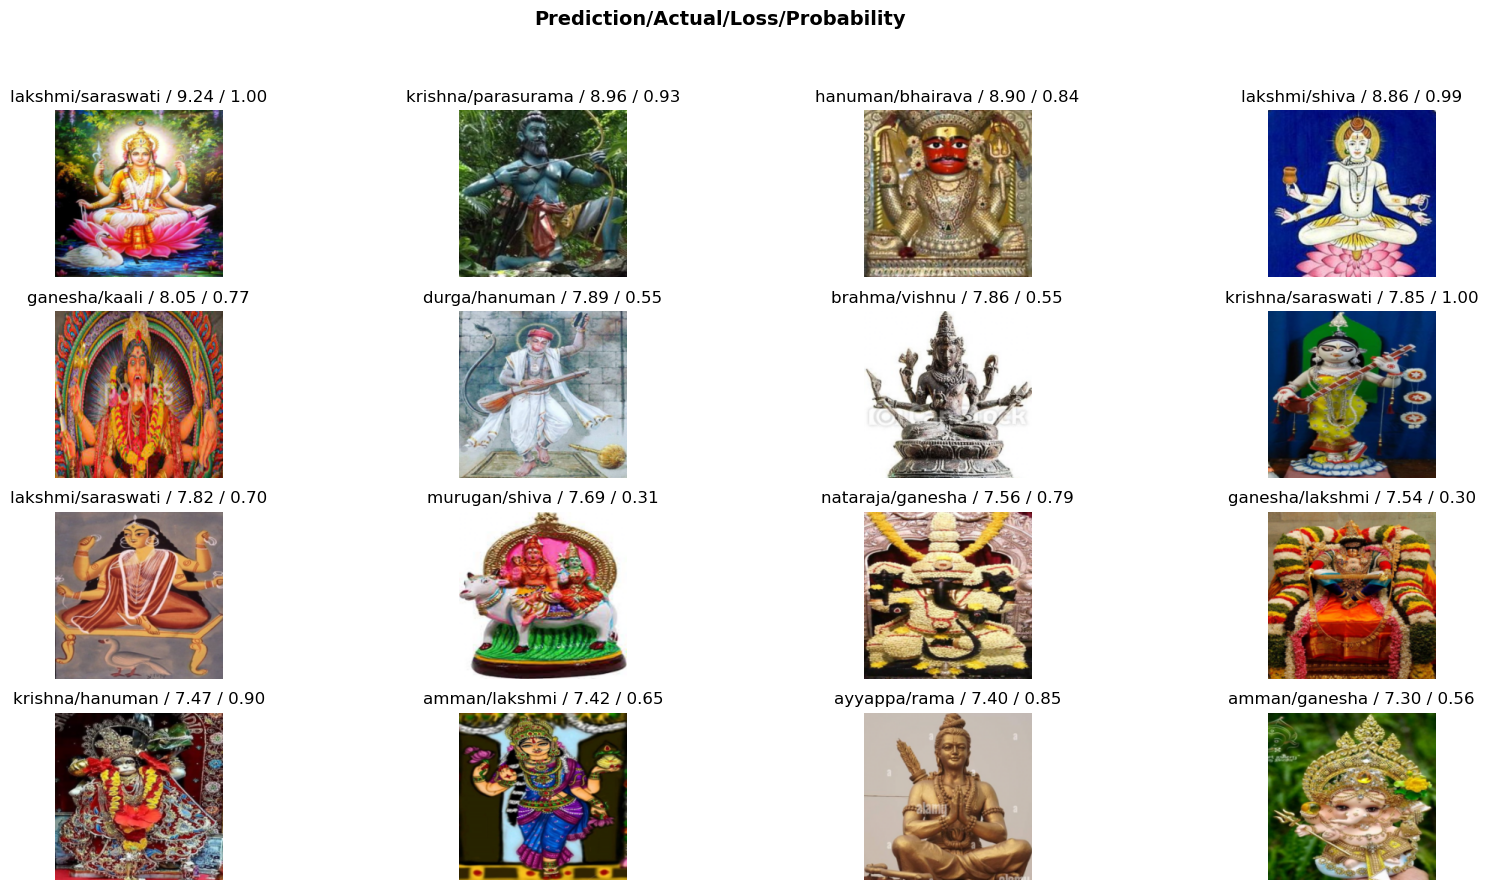

In [32]:
interp.plot_top_losses(16, figsize=(20,10))